<a href="https://colab.research.google.com/github/shreyus3003/CMPE297_sec49/blob/master/Assignment_1_Part_1/Assign1_part1_MIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os 
import tensorflow as tf
import time 

import numpy as np
import pandas as pd

import torch
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from torch import nn, optim
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from torch.utils.data import DataLoader

import inspect
import tensorflow as tf

from tqdm.autonotebook import tqdm




In [3]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
start_ts = time.time()

In [6]:
class M_resnet(ResNet):
  def __init__(self):
    super(M_resnet, self).__init__(BasicBlock, [2,2,2,2], num_classes = 10)
    self.conv1 = torch.nn.Conv2d(1, 64, kernel_size = (7,7), stride=(2,2), padding=(3,3), bias=False)
  
  def forward(self, x):
    return torch.softmax(super(M_resnet, self).forward(x), dim=-1)

In [9]:
def metrics_cal( metric_fn, true_y, pred_y):
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)

def display_scores(p, r, f1, a, batch_size):
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p,r,f1,a)):
    print(f"\t{name.rjust(14,' ')}: {sum(scores)/batch_size:4f}")


def load_data(train_batch_size, val_batch_size):
  mnist = MNIST(download=True, train=True, root=".").train_data.float()
  d_transform = Compose([Resize((224,224)), ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])
  dataset_train = MNIST(download=True, root=".", transform=d_transform, train=True)
  dataset_val = MNIST(download=False, root=".", transform=d_transform, train=False)
  
  train_set, a  = torch.utils.data.random_split(dataset_train, [15000, 45000])
  val_set, b = torch.utils.data.random_split(dataset_val, [4000,6000])

  train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=val_batch_size, shuffle=False)
  return train_loader, val_loader



In [5]:
train_batch_size = 256
val_batch_size = 256

train_loader, valid_loader = load_data(train_batch_size, val_batch_size)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [12]:
# Load the model:
model = M_resnet().to(device)

epochs = 6
train_loader, val_loader = load_data(train_batch_size, val_batch_size)
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adadelta(model.parameters())

losses = []
batches = len(train_loader)
val_batches = len(val_loader)
print(batches)
val_batches

for epoch in range(epochs):
  total_loss = 0

  progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
  model.train()

  for i, data in progress:
    X, y = data[0].to(device), data[1].to(device)
    model.zero_grad()

    outputs = model(X)
    loss = loss_function(outputs, y)
    loss.backward()
    optimizer.step()
    current_loss = loss.item()
    total_loss += current_loss

    progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

  if torch.cuda.is_available():
    torch.cuda.empty_cache()

  val_losses = 0
  precision, recall, f1, accuracy = [], [], [], []

  model.eval()
  with torch.no_grad():
    for i, data in enumerate(val_loader):
      X, y = data[0].to(device), data[1].to(device)

      outputs = model(X)
      val_losses += loss_function(outputs, y)
      predicted_classses = torch.max(outputs, 1)[1]

      for acc, metric in zip((precision, recall, f1, accuracy),
                             (precision_score, recall_score, f1_score, accuracy_score)):
        acc.append(metrics_cal(metric, y.cpu(), predicted_classses.cpu()))

  print(f"epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss : {val_losses/val_batches}")
  display_scores(precision, recall, f1, accuracy, val_batches)
  losses.append(total_loss/batches)
print(f"Training time : {time.time()-start_ts}s")        
    


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


59


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 1/6, training loss: 1.9181517746488927, validation loss : 2.1660220623016357
	     precision: 0.456751
	        recall: 0.277234
	            F1: 0.256845
	      accuracy: 0.282861



epoch 2/6, training loss: 1.6183263649374753, validation loss : 1.5963876247406006
	     precision: 0.800515
	        recall: 0.864660
	            F1: 0.826279
	      accuracy: 0.874219



epoch 3/6, training loss: 1.5483136237677881, validation loss : 1.5647293329238892
	     precision: 0.928394
	        recall: 0.917981
	            F1: 0.913883
	      accuracy: 0.919727



epoch 4/6, training loss: 1.486597515768924, validation loss : 1.5250197649002075
	     precision: 0.952654
	        recall: 0.950095
	            F1: 0.947900
	      accuracy: 0.950537



epoch 5/6, training loss: 1.4766317666587183, validation loss : 1.5705106258392334
	     precision: 0.930822
	        recall: 0.903625
	            F1: 0.905631
	      accuracy: 0.903955



epoch 6/6, training loss: 1.473381590035002, validation loss : 1.7643616199493408
	     precision: 0.802714
	        recall: 0.708514
	            F1: 0.701668
	      accuracy: 0.702246
Training time : 1164.43728017807s


In [13]:
torch.save(model.state_dict(), 'supervis_mnist.pt')

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [15]:
x_train = x_train[:14001]
y_train = y_train[:14001]

x_test = x_test[:3000]
y_test = y_test[:3000]

In [17]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 225
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

x_train: (14001, 28, 28)
x_test: (3000, 28, 28)


In [ ]:
inst_index_label = [(i, y_train[i]) for i in range(x_train.shape[0])]
inst_index_label_test = [(i, y_test[i]) for i in range(x_test.shape[0])]
inst_index_label

In [21]:
f_index = [inst_index_label[i][0] for i in range(len(inst_index_label)) if inst_index_label[i][1]==1]
f_index_test = [inst_index_label_test[i][0] for i in range(len(inst_index_label_test)) if inst_index_label_test[i][1]==1]

In [27]:
model = M_resnet()
model.load_state_dict(torch.load('/content/supervis_mnist.pt'))
body = nn.Sequential(*list(model.children()))
model = body[:9]
model.eval()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

# Extract Features

In [28]:
train_batch_size = 1
val_batch_size = 1
train_loader, val_loader = load_data(train_batch_size, val_batch_size)
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adadelta(model.parameters())

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [29]:
losses = []
batches = len(train_loader)
val_batches = len(val_loader)

#Extract features for train:

In [30]:
meta_table = dict()
feature_res = []

progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

model.eval()
for i, data in progress:
  if i == 14001:
    break
  X, y = data[0], data[1]
  model.zero_grad()
  outputs = model(X)
  feature_res.append(outputs.reshape(-1).tolist())
  meta_table[i] = outputs.reshape(-1).tolist()

f_array = np.array(feature_res)
np.save('f_array_full', f_array)

In [61]:
f_array = np.load('/content/f_array_full.npy', allow_pickle=True)

# Extract Features for test:

In [34]:
meta_table = dict()
f_test_res = []

progress = tqdm(enumerate(val_loader), desc="Loss: ", total=val_batches)

model.eval()
for i, data in progress:
  if i == 3000:
    break
  X, y = data[0], data[1]
  model.zero_grad()
  outputs = model(X)
  f_test_res.append(outputs.reshape(-1).tolist())
  meta_table[i] = outputs.reshape(-1).tolist()

ft_array = np.array(f_test_res)
np.save('ft_array_full', ft_array)

In [60]:
ft_array = np.load('/content/drive/My Drive/assign1_DL/ft_array_full.npy', allow_pickle=True)

In [37]:
# ! cp /content/f_array_full.npy "/content/drive/My Drive/assign1_DL"
# ! cp /content/ft_array_full.npy "/content/drive/My Drive/assign1_DL"

# Create training Data:

In [76]:
from typing import List, Dict, Tuple
import copy

def gen_data(inst_index_label: List[Tuple]) -> List[Dict]:
  bag_size = np.random.randint(3,7,size=(len(inst_index_label))//5)
    
  data_cp = copy.copy(inst_index_label)
  np.random.shuffle(data_cp)
  bags = {}
  bags_per_instance_labels = {}
  bags_labels = {}
  
  for bag_ind, size in enumerate(bag_size):
      bags[bag_ind] = []
      bags_per_instance_labels[bag_ind] = []
      try:
          for _ in range(size):
              inst_ind, lbl = data_cp.pop()
              bags[bag_ind].append(inst_ind)
              bags_per_instance_labels[bag_ind].append(lbl)
          bags_labels[bag_ind] = bag_label_from_instance_labels(bags_per_instance_labels[bag_ind])
      except:
          break
  return bags, bags_labels

def bag_label_from_instance_labels(instance_labels):
    return int(any(((x==1) for x in instance_labels)))
                          

In [ ]:
bag_indices, bag_labels = gen_data(inst_index_label)
#print(feature_array)

bag_features = {kk: torch.Tensor(f_array[inds]) for kk, inds in bag_indices.items()}
print(bag_features)

In [80]:
bag_t_indices, bag_t_labels = gen_data(inst_index_label_test)
bag_t_features = {kk: torch.Tensor(ft_array[inds]) for kk, inds in bag_t_indices.items()}

In [47]:
! cd /content/

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [84]:
train_data = [(bag_features[i],bag_labels[i]) for i in range(len(bag_features))]
bag_features[0]

tensor([[1.1818, 1.2626, 1.9718,  ..., 0.9811, 0.7399, 0.6508],
        [1.7176, 0.0720, 1.0232,  ..., 0.0195, 0.1820, 0.7949],
        [0.7418, 0.0864, 0.1953,  ..., 0.1456, 0.0810, 0.1549],
        [0.2397, 1.8663, 0.8743,  ..., 1.8743, 0.9468, 0.4713]])

In [85]:
def pad_tensor(data:list, max_number_instance) -> list:
    new_data = []
    for bag_index in range(len(data)):
        tensor_size = len(data[bag_index][0])
        pad_size = max_number_instance - tensor_size
        p2d = (0,0, 0, pad_size)
        padded = nn.functional.pad(data[bag_index][0], p2d, 'constant', 0)
        new_data.append((padded, data[bag_index][1]))
    return new_data

In [86]:
max_number_instance = 7
padded_train = pad_tensor(train_data, max_number_instance)

In [87]:
test_data = [(bag_t_features[i],bag_t_labels[i]) for i in range(len(bag_t_features))]
padded_test = pad_tensor(test_data, max_number_instance)

In [88]:
def load_data(train_data, test_data, train_batch_size, val_batch_size):
    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [90]:
train_loader,valid_loader = load_data(padded_train, padded_test, 1, 1)
train_batch_size = 1
val_batch_size = 1

In [97]:
class NN(torch.nn.Module):

    def __init__(self, n=7*512, n_mid = 7168, n_out=1, dropout=0.2):
        super(NN, self).__init__()
        self.linear1 = torch.nn.Linear(n, n_mid)
        self.linear2 = torch.nn.Linear(n_mid, n_out)
        self.dropout = torch.nn.Dropout(dropout)
        self.non_linearity = torch.nn.LeakyReLU()
        
    def forward(self, x):
        z = self.linear1(x)
        z = self.non_linearity(z)
        z = self.dropout(z)
        z = self.linear2(z)
        y_pred = torch.sigmoid(z)
        return y_pred

class NoisyAnd(torch.nn.Module):
    def __init__(self, a=10, dims=[0]):
        super(NoisyAnd, self).__init__()
        self.a = a
        self.b = torch.nn.Parameter(torch.tensor(0.01))
        self.dims =dims
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        mean = torch.mean(x, self.dims, False)
        res = (self.sigmoid(self.a * (mean - self.b)) - self.sigmoid(-self.a * self.b)) / (
              self.sigmoid(self.a * (1 - self.b)) - self.sigmoid(-self.a * self.b))
        return res
    

class MIL_NN(torch.nn.Module):

    def __init__(self, n=7*512,  n_mid=7168, n_out=1, 
                 n_inst=None, dropout=0.1,
                 noisy_a=4,
                 agg = NoisyAnd(a=4, dims=[0]),
                ):
        super(MIL_NN, self).__init__()
        if agg is None:
            agg = NoisyAnd(a=noisy_a, dims=[0])
        if n_inst is None:
            self.mdl_instance = agg
            n_inst = n
        else:
            self.mdl_instance = nn.Sequential(
                            nn.Linear(n, n_inst),
                            nn.LeakyReLU(),
                            agg,
                            )
        if n_mid == 0:
            self.mdl_bag = LogisticRegression(n_inst, n_out)
        else:
            self.mdl_bag = NN(n_inst, n_mid, n_out, dropout=dropout)
        
    def forward(self, bag_feature):

        y_pred = self.mdl_bag(bag_feature)
        return y_pred

In [129]:
import matplotlib.pyplot as plt

def display_scores(p, r, f1, a, batch_size):
  a = (np.sum(a)/batch_size)
  # print(a)
  print(f"\tAccuracy: {a:4f}")
  
  # for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p,r,f1,a)):
  # for name, scores in zip(("accuracy"), (a)):
  #   print(name)
  #   print(scores)
  #   print(f"\t{name.rjust(14,' ')}: {sum(scores)/batch_size:4f}")

def plot_validation(tr_loss, tes_loss):
  epoch_count = range(1, len(tr_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, tr_loss, 'r--')
  plt.plot(epoch_count, tes_loss, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

In [131]:
import warnings
warnings.filterwarnings('ignore')
lr0 = 1e-4

model = MIL_NN().to(device)

epochs = 10
train_loader, val_loader = load_data(padded_train, padded_test, 1, 1)
loss_function = torch.nn.BCELoss(reduction='mean')      


optimizer = optim.SGD(model.parameters(), lr=lr0, momentum=0.9)

losses = []
batches = len(train_loader)
val_batches = len(val_loader)
t_loss = []
v_loss = []

for epoch in range(epochs):
    total_loss = 0


    # progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)


    model.train()
    # for i, data in progress:
    for i, data in enumerate(train_loader):
        X, y = data[0].to(device), data[1].to(device)
        X = X.reshape([1,7*512])
        y = y.type(torch.cuda.FloatTensor)
      
        model.zero_grad()

        outputs = model(X)                             
        loss = loss_function(outputs, y)               
        loss.backward()                                
        optimizer.step()                            

        
        current_loss = loss.item()
        total_loss += current_loss

     
        # progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            X = X.reshape([1,7*512])
            y = y.type(torch.cuda.FloatTensor)
            outputs = model(X)                        
            prediced_classes =outputs.detach().round()
            val_losses += loss_function(outputs, y)
            
            
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    metrics_cal(metric, y.cpu(), prediced_classes.cpu())
                )
    t_loss.append(total_loss/batches)
    v_loss.append(val_losses/val_batches)   
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    display_scores(precision, recall, f1, accuracy, val_batches)

    # print_scores(accuracy, val_batches)
    losses.append(total_loss/batches)                  
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/10, training loss: 0.7288772944520627, validation loss: 0.752399206161499
	Accuracy: 0.531667
Epoch 2/10, training loss: 0.6815123235860041, validation loss: 0.6914316415786743
	Accuracy: 0.573333
Epoch 3/10, training loss: 0.6632336030261857, validation loss: 0.6915848851203918
	Accuracy: 0.566667
Epoch 4/10, training loss: 0.6548186377728624, validation loss: 0.6848378777503967
	Accuracy: 0.576667
Epoch 5/10, training loss: 0.6416550201656563, validation loss: 0.7100945115089417
	Accuracy: 0.551667
Epoch 6/10, training loss: 0.6323641132962491, validation loss: 0.7179750204086304
	Accuracy: 0.561667
Epoch 7/10, training loss: 0.6215595753051872, validation loss: 0.7536075711250305
	Accuracy: 0.493333
Epoch 8/10, training loss: 0.6122215927046325, validation loss: 0.7227935194969177
	Accuracy: 0.560000
Epoch 9/10, training loss: 0.5999849742424808, validation loss: 0.7370573878288269
	Accuracy: 0.561667
Epoch 10/10, training loss: 0.5944194277469069, validation loss: 0.7496514

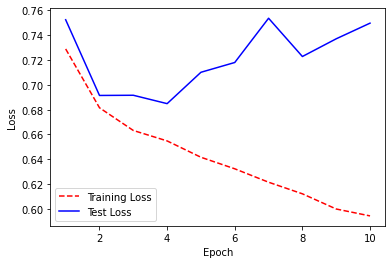

In [132]:
plot_validation(t_loss, v_loss)